# **QW network QPS for Scenario 1**

This Jupyter notebook investigates QPS with QW network in a specific transfer learning scenario.
see: Xing Tang, Jiameng Tian, Tian Chen, and Xiangdong Zhang: Optical quantum walk platforms for interpretable quantum machine learning.
The code is modified from https://github.com/MariusKrumm/PhotonicsPS.

In [7]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from joblib import Parallel, delayed

In [8]:
# This is for saving figures and the data used to draw them
dirNameFigures = "TransferFigures"
if not os.path.exists(dirNameFigures):
    os.mkdir(dirNameFigures)
  
# This is for saving PyTorch models
dirNameModels = "TransferModels"
if not os.path.exists(dirNameModels):
    os.mkdir(dirNameModels)
    
# This is for saving PyTorch parameters
dirNameParameters = "TransferParameters"
if not os.path.exists(dirNameParameters):
    os.mkdir(dirNameParameters)
    
dirNameUnitaries = "TransferUnitaries"
if not os.path.exists(dirNameUnitaries):
    os.mkdir(dirNameUnitaries)

In [9]:
fixRNG = True

if fixRNG:
    torch.manual_seed(31337)
    np.random.seed(31337)

In [1]:
# Construct quantum walk networks
def coin_operator(phases):
    """
    Defines a universal 2x2 unitary coin
    """
    M = torch.tensor([[1.0+1.0j , 1.0+1.0j],[1.0+1.0j , 1.0+1.0j]])
    M[0,0] = torch.exp(1j*phases[0])*torch.cos(phases[1])
    M[0,1] = -torch.sin(phases[1]) 
    M[1,0] = torch.exp(1j*phases[0])*torch.sin(phases[1])
    M[1,1] = torch.cos(phases[1])
    return M
def shift_operator(N):
    """
    Parameters:
        N: Number of positions (x ∈ [0, N-1])
    Returns:
        2N × 2N permutation matrix representing S'
    """
    total_states = 2 * N
    S_prime = torch.zeros((total_states, total_states), dtype=torch.cfloat)
    for i in range(total_states):
        x = i // 2  # Position index
        c = i % 2   # Coin state (0 or 1)
        if x == 0 and c == 0:  # Left boundary, moving left
            j = 2 * x + 1      # Stay at x=0 but flip coin
        elif x == (N-1) and c == 1:  # Right boundary, moving right
            j = 2 * x              # Stay at x=N-1 but flip coin
        else:
            if c == 0:  # Moving left
                new_x = x - 1
                new_c = 0     # Coin remains 0 after left move
            else:       # Moving right
                new_x = x + 1
                new_c = 1     # Coin remains 1 after right move
            j = 2 * new_x + new_c
        S_prime[j, i] = 1.0 + 0j
    return S_prime
def block_diagonal_operator(N,parameters):
    """
    Construct block diagonal matrix ⊕_x U_{t,x}^{coin}-Implements the block diagonal structure
    """
    total_states = 2 * N
    U_block = torch.zeros((total_states, total_states), dtype=torch.cfloat)
    # Apply coin operator to each position
    for x in range(N):
        phase = parameters[x]
        U_coin = coin_operator(phase)
        # Place the coin operator in the block diagonal matrix
        start_idx = 2 * x
        U_block[start_idx:start_idx+2, start_idx:start_idx+2] = U_coin
    return U_block

def U_total(N, parameters, outputphase):
    """Total quantum walk evolution operator (corrected matrix multiplication order)"""
    total_steps = parameters.shape[0]
    if total_steps != 2 * N or parameters.shape[1] != N or parameters.shape[2] != 2:
        raise ValueError(f"Parameters must be of shape [2N, N, 2], current is {parameters.shape}, N={N}")
    S_prime = shift_operator(N)
    total_states = 2 * N
    U = torch.eye(total_states, dtype=torch.cfloat)
    for t in range(total_steps):
        # Split matrix multiplication: first coin operation × U, then S' × result
        coin_block = block_diagonal_operator(N, parameters[t])  # Get parameters for step t (shape [N,2])
        U = torch.matmul(S_prime, torch.matmul(coin_block, U))  # Correct two-step multiplication
    if outputphase is not None:
        U = torch.matmul(torch.diag(torch.exp(1j * outputphase)), U)
    return U

In [41]:
def TreeLayer( InputState, Phases, num_MZI):
    for m in range(num_MZI):
        CurrentState = torch.zeros(size = [2,1] , dtype = torch.cfloat)
        CurrentState[0,0] = InputState[m,0]
        CurrentState = torch.matmul(coin_operator(Phases[2*m : 2*m+2]) , CurrentState)
        if m == 0:
            StateSoFar = CurrentState
        else:
            StateSoFar = torch.cat([StateSoFar, CurrentState])
    return StateSoFar
def Tree(dim, TreePhases, OutputPhases):
    """
    The full tree, implemented by multiplying the layers. For simplicity, we assume
    that the phases are provided in a rectangular arrays, with the first index labeling
    the layer and the second the position in the layer. The drawback is that many of
    the phases in this array do not actually get used.
    """
    num_layers = int(np.ceil(np.log2(dim)))
    LayerOut = torch.tensor([[1.0 +0.00j]])
    for layer in range(num_layers):
        if layer < num_layers - 1:
            LayerOut = TreeLayer(LayerOut, Phases = TreePhases[layer, :] , num_MZI = LayerOut.size(0))
        elif layer == num_layers - 1:

            LastNumMZI = (dim - (2**(num_layers - 1))) 
            WorkState = LayerOut[0:LastNumMZI, :]      #Input to last layer
            Remaining = LayerOut[LastNumMZI : , :]     #Parallel waveguides
            WorkState = TreeLayer(WorkState, TreePhases[layer , :], LastNumMZI)
            LayerOut = torch.cat([WorkState, Remaining], )
            LayerOut = torch.matmul(torch.diag(torch.exp(1.0j*OutputPhases)) , LayerOut)
    return LayerOut


## Toy model for transfer learning: The scenario of Eva et al.

In [42]:
num_observables = 2
num_values = 3 #number of values each observable can take

In [43]:
One_Obs_Exps = []
experiment_index = 0

for obs in range(num_observables):
    for value in range(num_values):
        exp_title = 'Experiment '+str(experiment_index)+' checks whether observable '
        exp_title += str(obs)+' has value '+str(value)
        One_Obs_Exps.append( [exp_title , obs, value])
        experiment_index += 1
        
Two_Obs_Exps = []
experiment_index = 0

for obs1 in range(0, num_observables-1, 1):
    #We don't want several copies of the same experiment. Therefore, we make the convention that obs2 is always larger than obs1.
    for obs2 in range(obs1+1, num_observables, 1):
        for value1 in range(num_values):
            for value2 in range(num_values):
                exp_title = 'Experiment '+str(experiment_index)+' checks whether observable '
                exp_title += str(obs1)+' has value '+str(value1) +' and whether observable '
                exp_title += str(obs2)+' has value '+str(value2)
                Two_Obs_Exps.append( [exp_title , obs1, value1, obs2, value2])
                experiment_index += 1

In [44]:
def rewardLayer2(percept, predicted_answer):
    chosenObs = predicted_answer // num_values
    chosenValue = predicted_answer % num_values

    if percept[chosenObs] == chosenValue:
        return 1
    else:
        return -1

In [45]:
def rewardLayer3(percept, experiment_index, predicted_answer , experiment_list = One_Obs_Exps):
    rightAnswer = 1
    for targetObsInd, targetValueInd in zip(range(1, len(experiment_list[experiment_index]), 2) , range(2, len(experiment_list[experiment_index]), 2)):
        #Read observable and the value asked for by the experiment
        obs = experiment_list[experiment_index][targetObsInd]
        suggested_value = experiment_list[experiment_index][targetValueInd]
        actual_value = percept[obs]
        if suggested_value != actual_value:
            #rightAnswer is 1 if the observable value asked for by the experiment is the actual value of the percept, otherwise 0.
            rightAnswer = 0

    if rightAnswer == predicted_answer:
        return 1, rightAnswer
    else:
        return -1, rightAnswer

In [46]:
print(Two_Obs_Exps[3])
rewardLayer3([1,0], 3 , 1, Two_Obs_Exps)

['Experiment 3 checks whether observable 0 has value 1 and whether observable 1 has value 0', 0, 1, 1, 0]


(1, 1)

In [47]:
def MultiPSlossFunction(pGuesses, pOlds, rewards):
    """
    PS loss function using the approximation p_{new , k} = p_{old , k} + r_k for chosen actions a_k.
    This function is intended to be used with experience replay, and k is the index of the sample in the batch.
    Non-chosen actions and percepts are dropped, we only reinforce rewards, not old models.
    """
    relu = torch.nn.ReLU()
    pTargets = relu(pOlds+torch.tensor(rewards))
    pTargets = 1.0 - relu(1.0 - pTargets)
    
    # We use regularizers to prevent log(0) and division by 0
    reguLow = torch.tensor(0.00001)
    reguHigh = torch.tensor(1.00001)
    
    Loss = torch.sum(pTargets*torch.log((pTargets+reguLow)/(pGuesses+reguLow)) + (1.0-pTargets)*torch.log((reguHigh-pTargets)/(reguHigh-pGuesses)))
    #print(Loss)
    return(Loss)

In [50]:
class QPSTreeOneExp(nn.Module):
    def __init__(self, num_percepts=num_values**num_observables, num_hidden=num_observables*num_values, ini="fixed"):
        super(QPSTreeOneExp, self).__init__()
        self.num_percepts = num_percepts
        self.num_hidden = num_hidden  # Dimension of the hidden layer
        
        # Number of positions N in quantum walk: rounded up to half the hidden layer dimension
        self.N = int(np.ceil(num_hidden / 2))  # N = ceil(num_hidden / 2)
        self.qw_total_dim = 2 * self.N  # Total dimension of quantum walk (2N)
        
        self.U_percept_bag = []  # Store original intermediate layer output column vectors (num_hidden×1)
        self.U_percept_padded = []  # Store zero-padded column vectors (2N×1)
        self.U_full_bag = []  # Final output column vectors (2N×1)
        
        self.ini = ini
        
        # Parameters from perceptron to intermediate layer (fixed; each MZI requires 2 phases)
        if ini == "fixed":
            self.CPhases_percept_bag = nn.Parameter(
                (torch.pi/4) * torch.ones(
                    size=[num_percepts, int(np.ceil(np.log2(self.num_hidden))), self.num_hidden],
                    dtype=torch.float32
                )
            )
            self.OPhases_percept_bag = nn.Parameter(
                (torch.pi/4) * torch.ones(size=[num_percepts, self.num_hidden], dtype=torch.float32)
            )
        if ini == "random":
            self.CPhases_percept_bag = nn.Parameter(
                (2.0*torch.pi) * torch.randn(
                    size=[num_percepts, int(np.ceil(np.log2(self.num_hidden))), self.num_hidden],
                    dtype=torch.float32
                )
            )
            self.OPhases_percept_bag = nn.Parameter(
                (2.0*torch.pi) * torch.randn(size=[num_percepts, self.num_hidden], dtype=torch.float32)
            )
        
        # Quantum walk parameters (corrected: each position contains 2 phases, shape [2N, N, 2])
        if ini == "fixed":
            self.QWPhases_task_bag = nn.Parameter(
                (torch.pi/4) * torch.ones(size=[2*self.N, self.N, 2], dtype=torch.float32)  # Last dimension: 2 phases
            )
            self.OPhases_task_bag = nn.Parameter(
                (torch.pi/4) * torch.ones(size=[self.qw_total_dim], dtype=torch.float32)
            )
        if ini == "random":
            self.QWPhases_task_bag = nn.Parameter(
                (2.0*torch.pi) * torch.randn(size=[2*self.N, self.N, 2], dtype=torch.float32)  # Last dimension: 2 phases
            )
            self.OPhases_task_bag = nn.Parameter(
                (2.0*torch.pi) * torch.randn(size=[self.qw_total_dim], dtype=torch.float32)
            )
        
        # Initialize column vector storage (fixed)
        for p in range(num_percepts):
            self.U_percept_bag.append(torch.zeros(size=[self.num_hidden, 1], dtype=torch.cfloat))
            self.U_percept_padded.append(torch.zeros(size=[self.qw_total_dim, 1], dtype=torch.cfloat))
            self.U_full_bag.append(torch.zeros(size=[self.qw_total_dim, 1], dtype=torch.cfloat))
        
        self.recalculate_full_unitaries()
    
    def pad_state_vector(self, vector, target_dim):
        """Pad the column vector (num_hidden×1) to target_dim×1 with zeros"""
        padded = torch.zeros(size=[target_dim, 1], dtype=vector.dtype)
        padded[:vector.size(0), 0] = vector[:, 0]
        return padded
    
    def reset_task(self):
        if self.ini == "fixed":
            self.QWPhases_task_bag = nn.Parameter(
                (torch.pi/4) * torch.ones(size=[2*self.N, self.N, 2], dtype=torch.float32)
            )
            self.OPhases_task_bag = nn.Parameter(
                (torch.pi/4) * torch.ones(size=[self.qw_total_dim], dtype=torch.float32)
            )
        if self.ini == "random":
            self.QWPhases_task_bag = nn.Parameter(
                (2.0*torch.pi) * torch.randn(size=[2*self.N, self.N, 2], dtype=torch.float32)
            )
            self.OPhases_task_bag = nn.Parameter(
                (2.0*torch.pi) * torch.randn(size=[self.qw_total_dim], dtype=torch.float32)
            )
        self.recalculate_full_unitaries()
    
    def convert_percept_to_index(self, percept):
        """Handle integer indices or percept lists"""
        if isinstance(percept, int):
            return percept
        onedimvalue = 0
        for j in range(num_observables):
            onedimvalue += (num_values**j) * percept[j]
        return onedimvalue
    
    def recalculate_percept_unitary(self, percept):
        percept_index = self.convert_percept_to_index(percept)
        self.U_percept_bag[percept_index] = Tree(
            dim=self.num_hidden,
            TreePhases=self.CPhases_percept_bag[percept_index],
            OutputPhases=self.OPhases_percept_bag[percept_index]
        )
        self.U_percept_padded[percept_index] = self.pad_state_vector(
            self.U_percept_bag[percept_index], 
            self.qw_total_dim
        )
    
    def recalculate_full_unitary(self, percept, is_index=0):
        if is_index == 0:
            percept_index = self.convert_percept_to_index(percept)
        else:
            percept_index = percept
        
        self.recalculate_percept_unitary(percept)
        
        # Calculate the total evolution operator of the quantum walk (using corrected parameter shape [2N, N, 2])
        self.U_task = U_total(
            N=self.N,
            parameters=self.QWPhases_task_bag,
            outputphase=self.OPhases_task_bag
        )
        
        self.U_full_bag[percept_index] = torch.matmul(
            self.U_task,
            self.U_percept_padded[percept_index]
        )
    
    def recalculate_full_unitaries(self):
        for percept_index in range(self.num_percepts):
            self.recalculate_full_unitary(percept_index, is_index=1)
    
    def probs2(self, percept):
        self.recalculate_percept_unitary(percept)
        percept_index = self.convert_percept_to_index(percept)
        torchUnnormedProbs = torch.square(torch.abs(self.U_percept_bag[percept_index][:, 0]))
        torchNormedProbs = torchUnnormedProbs / torch.sum(torchUnnormedProbs)
        return torchNormedProbs.clone()
    
    def sample2(self, percept):
        torchProbs = self.probs2(percept)
        probs = torchProbs.clone().detach().numpy()
        sampled_action = np.random.choice(np.arange(self.num_hidden), p=probs)
        return sampled_action
    
    def probs2Observables(self, percept):
        torchProbs = self.probs2(percept)
        probsObs = torch.zeros(size=[num_observables], dtype=torch.float32)
        for obsIndex in range(num_observables):
            probsObs[obsIndex] = torch.sum(torchProbs[obsIndex*num_values : obsIndex*num_values + num_values])
        return probsObs
    
    def phases2(self, percept):
        self.recalculate_percept_unitary(percept)
        percept_index = self.convert_percept_to_index(percept)
        phases = torch.zeros(size=[self.num_hidden], dtype=torch.cfloat)
        for j in range(self.num_hidden):
            if self.U_percept_bag[percept_index][j, 0] != 0.0:
                phases[j] = torch.angle(self.U_percept_bag[percept_index][j, 0].clone())
            else:
                phases[j] = 0.0
        return phases
    
    def probs3(self, percept):
        self.recalculate_full_unitary(percept)
        percept_index = self.convert_percept_to_index(percept)
        torchUnnormedProbs = torch.square(torch.abs(self.U_full_bag[percept_index][0:2, 0]))
        torchNormedProbs = torchUnnormedProbs / torch.sum(torchUnnormedProbs)
        return torchNormedProbs
    
    def sample3(self, percept):
        torchNormedProbs = self.probs3(percept)
        probs = torchNormedProbs.clone().detach().numpy()
        sampled_action = np.random.choice(np.arange(torchNormedProbs.size(0)), p=probs)
        return sampled_action

In [51]:
#ini_choice = "random"
ini_choice = "fixed"

TreeAgent = QPSTreeOneExp(num_percepts = num_values**num_observables, num_hidden = num_values*num_observables, ini = ini_choice)

In [52]:
def train_obs_with_replay(Agent, replay_memory_size = 600, 
                         num_rounds = 20000, num_optimizer_steps = 10, 
                         coeff_Shannon = 1.0, coeff_phase = 0.01, learning_rate = 0.01):
    """Train the intermediate layer network using experience replay"""
    
    # Create directories for saving results
    dirNameFigures = "./figures"
    dirNameModels = "./models"
    dirNameUnitaries = "./unitaries"
    dirNameParameters = "./parameters"
    
    for dir_name in [dirNameFigures, dirNameModels, dirNameUnitaries, dirNameParameters]:
        os.makedirs(dir_name, exist_ok=True)
    
    logfile_path = f"{dirNameFigures}/logfile_obs.txt"
    
    # Experience replay memory buffers
    reward_memory = []
    percept_memory = []
    action_memory = []

    # Data collection for plotting
    round_list = []
    Shannon_list = []
    acc_list = []
    phase_list = []

    # Accuracy tracking parameters
    num_acc = replay_memory_size
    counter = 0
    accuracy = 0.0
    last_round_to_draw_open = True
    perfection = 0
    add_Shannon_and_perfection = False
    last_acc = 0.0  # Initialize last accuracy
    
    # Initialize optimizer with learnable parameters
    paramlist = [
        {'params': Agent.CPhases_percept_bag},
        {'params': Agent.OPhases_percept_bag}
    ]
    optimizer = optim.Adam(paramlist, lr=learning_rate)
    
    # Training loop
    for roun in range(num_rounds):
        counter += 1
        
        # Sample a random percept from the environment
        percept = [np.random.randint(num_values) for _ in range(num_observables)]
        
        # Store experience in replay memory
        percept_memory.append(percept.copy())
        agentGuess = Agent.sample2(percept)
        action_memory.append(agentGuess)
        r = 0.1 * rewardLayer2(percept, agentGuess)  # Calculate reward
        reward_memory.append(r)
        
        # Track correct predictions for accuracy calculation
        if r > 0.0:
            accuracy += 1.0
            
        # Periodically evaluate and log training accuracy
        if counter == num_acc:
            round_list.append(roun)
            accuracy /= num_acc
            acc_list.append(accuracy)
            print(f"Accuracy: {accuracy}")
            
            with open(logfile_path, "a") as logfile:
                logfile.write(f"Accuracy: {accuracy}\n")
                
            last_acc = accuracy
            accuracy = 0.0
            counter = 0
            add_Shannon_and_perfection = True
        
        # Train the agent once replay memory is full
        if len(reward_memory) == replay_memory_size:
            num_percepts = num_values ** num_observables
            
            # Adjust learning rate based on training progress
            if last_acc >= 0.95:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 0.1 * learning_rate
            
            # Compute old probabilities for comparison
            Agent.recalculate_full_unitaries()
            oldProbs = torch.zeros(size=[replay_memory_size], dtype=torch.float32)
            
            for memory_index in range(replay_memory_size):
                current_percept = percept_memory[memory_index].copy()
                probsGuessOld = Agent.probs2(percept=current_percept).clone().detach()
                oldProbs[memory_index] = probsGuessOld[action_memory[memory_index]].clone()

            # Optimization steps
            for step in range(num_optimizer_steps):
                Agent.recalculate_full_unitaries()
                optimizer.zero_grad()
                
                # Compute current probabilities and losses
                guessProbs = torch.zeros(size=[replay_memory_size], dtype=torch.float32)
                phasesForLoss = None
                probsGuessObs = None
                Shannon = 0.0
                weightedPhases = None
                
                for memory_index in range(replay_memory_size):
                    current_percept = percept_memory[memory_index].copy()
                    probsGuessFullPercept = Agent.probs2(percept=current_percept)
                    guessProbs[memory_index] = probsGuessFullPercept[action_memory[memory_index]].clone()
                    current_phases = Agent.phases2(percept=current_percept)
                    current_probs_obs = Agent.probs2Observables(percept=current_percept)
                    
                    # Calculate Shannon entropy for observables
                    eps = 1e-10
                    current_Shannon = torch.log(torch.tensor(num_observables)) - torch.sum(
                        -current_probs_obs.clone() * torch.log(current_probs_obs.clone().clamp(min=eps))
                    )
                    
                    # Initialize or accumulate metrics
                    if memory_index == 0:
                        phasesForLoss = current_phases
                        probsGuessObs = current_probs_obs
                        Shannon = current_Shannon
                        weightedPhases = Agent.probs2(percept=current_percept).clone().data * current_phases.clone().data
                    else:
                        phasesForLoss = torch.cat((phasesForLoss, current_phases), 0)
                        Shannon += current_Shannon
                        extraWeightedPhases = Agent.probs2(percept=current_percept).data * current_phases.data
                        weightedPhases = torch.cat((weightedPhases, extraWeightedPhases), 0)
                
                # Combine loss components
                phaseLoss = torch.sum(torch.abs(phasesForLoss))
                PSloss = MultiPSlossFunction(guessProbs, oldProbs.clone().detach(), reward_memory)
                fullLoss = coeff_phase * phaseLoss + 1.0 * PSloss + coeff_Shannon * Shannon
                fullLoss.backward()
                
                # Log training progress periodically
                if counter % 10 == 0 and step % 20 == 0:
                    with open(logfile_path, "a") as logfile:
                        log_entry = f"Amplitudes for percept [0,0,0]: \n{Agent.U_percept_bag[0].data}\n"
                        print(log_entry)
                        logfile.write(log_entry)

                # Update model parameters
                optimizer.step()
                optimizer.zero_grad()
                Agent.recalculate_full_unitaries()
            
            # Record training metrics
            if add_Shannon_and_perfection:
                add_Shannon_and_perfection = False
                ave_Shannon = Shannon.data / replay_memory_size
                Shannon_list.append(ave_Shannon.numpy())
                
                ave_weighted_phase = torch.sum(torch.abs(weightedPhases)) / replay_memory_size
                phase_list.append(ave_weighted_phase.data.numpy())
                
                with open(logfile_path, "a") as logfile:
                    log_entry = (
                        f"L1 norm of phases: {phaseLoss.data.numpy()}\n"
                        f"Average weighted phase: {phase_list[-1]}\n\n"
                    )
                    print(log_entry)
                    logfile.write(log_entry)
                
                # Early stopping conditions
                if last_acc >= 0.99 and phase_list[-1] < 0.1:
                    last_acc = 0.0
                    perfection += 1
                    if last_round_to_draw_open and len(round_list) > 0:
                        last_round_to_draw_open = False
                        last_round_to_draw = roun
                else:
                    perfection = 0

            # Clear replay memory for next cycle
            percept_memory = []
            action_memory = []
            reward_memory = []
            
        # Stop training if consistent perfection is achieved
        if perfection >= 10 and len(round_list) > 0:
            break
            
    # Generate training plots
    if len(round_list) > 0:
        last_idx = min(last_round_to_draw, len(round_list) - 1) if 'last_round_to_draw' in locals() else len(round_list) - 1
        
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(round_list[:last_idx+1], acc_list[:last_idx+1], 
                label='accuracy (1.0 means 100 percent)')  
        ax.plot(round_list[:last_idx+1], Shannon_list[:last_idx+1], 
                label='Shannon negentropy of observable choice (0.0 is uniform)')   
        ax.plot(round_list[:last_idx+1], phase_list[:last_idx+1], 
                label="Average phase weighted with action probability")
        ax.set_xlabel('round')  
        ax.set_ylabel(' ')  
        ax.set_title("Training of the middle layer with experience replay")  
        ax.legend()
        plt.savefig(f"{dirNameFigures}/obs_training.png")
        plt.show()
    else:
        print("Not enough training data to generate plot.")
    
    # Compute and log final metrics
    if len(reward_memory) > 0:
        ave_entropy = ((replay_memory_size * torch.log(torch.tensor(num_observables))) - Shannon) / replay_memory_size
        print(f"Last averaged observable Shannon entropy over {replay_memory_size} samples: {ave_entropy.data.numpy()}")
    else:
        print("No training data available to compute entropy.")
    
    # Save training data for analysis
    if len(round_list) > 0:
        save_data = lambda filename, data: np.savetxt(f"{dirNameFigures}/{filename}.txt", data[:last_idx+1])
        save_data("MiddleLayerRounds", round_list)
        save_data("MiddleLayerAccuracies", acc_list)
        save_data("MiddleLayerShannonNegEntropies", Shannon_list)
        save_data("MiddleLayerPhases", phase_list)
    
    # Save model parameters and unitary transformations
    torch.save(Agent.state_dict(), f"{dirNameModels}/MiddleLayerModel.pt")
    
    # Save percept-specific transformations and parameters
    for percept in range(Agent.num_percepts):
        write_mode = 'w' if percept == 0 else 'a'
        
        with open(f"{dirNameUnitaries}/PerceptTrafo.txt", write_mode) as datafile:
            datafile.write(f"Percept index:{percept} \n \n{Agent.U_percept_bag[percept].clone().data.numpy()}\n\n")
            
        with open(f"{dirNameParameters}/PerceptCPhases.txt", write_mode) as datafile:
            datafile.write(f"Percept index:{percept} \n \n{Agent.CPhases_percept_bag[percept].clone().data.numpy()}\n\n")
            
        with open(f"{dirNameParameters}/PerceptOPhases.txt", write_mode) as datafile:
            datafile.write(f"Percept index:{percept} \n \n{Agent.OPhases_percept_bag[percept].clone().data.numpy()}\n\n")

In [53]:
%%capture output_obs
train_obs_with_replay(Agent = TreeAgent, replay_memory_size = 500, num_rounds = 80000, num_optimizer_steps = 10, coeff_Shannon = 10.0, coeff_phase = 1.0, learning_rate = 0.01)

In [54]:
print(output_obs)

Accuracy: 0.366
Amplitudes for percept [0,0,0]: 
tensor([[-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+3.5355e-01j],
        [-0.3536+3.5355e-01j]])

L1 norm of phases: 7649.3798828125
Average weighted phase: 2.4924426078796387


Accuracy: 0.392
Amplitudes for percept [0,0,0]: 
tensor([[-0.4215+0.1782j],
        [-0.3450+0.1459j],
        [-0.3486+0.1474j],
        [-0.2903+0.1227j],
        [-0.2247+0.4260j],
        [-0.1956+0.3709j]])

L1 norm of phases: 6549.2265625
Average weighted phase: 2.1567392349243164


Accuracy: 0.43
Amplitudes for percept [0,0,0]: 
tensor([[-0.3679+0.3684j],
        [-0.2463+0.2467j],
        [-0.2691+0.2695j],
        [-0.2121+0.2124j],
        [-0.0847+0.4271j],
        [-0.0832+0.4193j]])

L1 norm of phases: 5449.775390625
Average weighted phase: 1.7828513383865356


Accuracy: 0.502
Amplitudes for percept [0,0,0]: 
tensor([[-0.2065+0.4970j],
        [-0.1091+0.2626j],

In [55]:
TreeAgent.U_percept_bag

[tensor([[7.0584e-01+1.5630e-03j],
         [1.7628e-05-1.7914e-05j],
         [2.2811e-02-3.3790e-07j],
         [6.9885e-01-1.0306e-05j],
         [7.5800e-02+2.8020e-05j],
         [8.4374e-02+3.1188e-05j]], grad_fn=<MmBackward0>),
 tensor([[1.1787e-05+2.9973e-04j],
         [7.0571e-01+6.4450e-05j],
         [3.8398e-02+1.7209e-05j],
         [6.9087e-01+3.0960e-04j],
         [1.0941e-01+1.8800e-05j],
         [1.0597e-01+1.8207e-05j]], grad_fn=<MmBackward0>),
 tensor([[0.0034+5.6982e-06j],
         [0.0031+5.2025e-06j],
         [0.7071+1.1683e-03j],
         [0.6971+1.1518e-03j],
         [0.0891+1.1043e-04j],
         [0.0777+9.6323e-05j]], grad_fn=<MmBackward0>),
 tensor([[ 7.0709e-01+3.1794e-04j],
         [ 9.3405e-05-1.6751e-04j],
         [ 1.3964e-02+8.9773e-06j],
         [ 1.1401e-02+7.3295e-06j],
         [ 7.0689e-01+8.8561e-05j],
         [-2.9867e-05-4.6449e-06j]], grad_fn=<MmBackward0>),
 tensor([[5.0208e-05-1.0675e-04j],
         [7.0601e-01+7.7241e-04j],
        

In [56]:
def trainOnExperimentsReplayProcess(experiment_index, Agent=TreeAgent, exp_list=One_Obs_Exps, 
                                   num_rounds=10000, replay_size=100, num_optimizer_steps=1, 
                                   learning_rate=0.01):
    """Train the task layer (adapted for quantum walk parameters)"""
    exp_index = experiment_index
    
    # Initialize log file
    logfile_path = f"{dirNameFigures}/logfile_exp_{exp_index}.txt"
    with open(logfile_path, "w") as f:
        f.write("Task layer training log\n")
    
    replay_memory_size = replay_size
    num_experiments = len(exp_list)
    num_obs_per_exp = (len(exp_list[0])-1) // 2  # Number of observables per experiment
    
    # Counters for metrics
    counter = 0
    accuracy = 0.0
    weighted_accuracy = 0.0
    for_full_accuracy = 0.0
    for_full_weighted_accuracy = 0.0
    normalization = 0.0
    
    # Replay memory buffers
    reward_memory = []
    percept_memory = []
    action_memory = []
    
    # Training curve records
    round_list = []
    acc_list = []
    weighted_list = []
    
    # Data for plotting
    exp_list_for_graph = []
    acc_exp_list = []
    weighted_exp_list = []

    exp_list_for_graph.append(experiment_index)
    Agent.reset_task()  # Reset task layer parameters (quantum walk parameters)
    
    # Record experiment information
    print(f"Experiment {experiment_index} configuration: {exp_list[experiment_index][0]}")
    with open(logfile_path, "a") as f:
        f.write(f"Experiment {experiment_index} configuration: {exp_list[experiment_index][0]}\n\n")
    
    for roun in range(num_rounds):
        counter += 1
        
        # Generate random percept (consistent with middle layer training)
        percept = [np.random.randint(num_values) for _ in range(num_observables)]
        percept_memory.append(percept.copy())
        
        # Sample action and compute reward (using layer 3 output)
        predicted_answer = Agent.sample3(percept)
        action_memory.append(predicted_answer)
        answeredRight, rightAns = rewardLayer3(percept, experiment_index, predicted_answer, experiment_list=exp_list)        
        r = 0.1 * answeredRight  # Reward scaling
        
        # Weighted reward (balance positive and negative samples)
        r *= ((num_values ** num_obs_per_exp) - 1.0) ** rightAns
        
        # Track accuracy metrics
        if r > 0.0:
            accuracy += 1.0
            weighted_accuracy += ((num_values ** num_obs_per_exp) - 1.0) ** rightAns
        normalization += ((num_values ** num_obs_per_exp) - 1.0) ** rightAns
        
        # Evaluate accuracy every replay_size samples
        if counter == replay_size:
            accuracy /= replay_size
            weighted_accuracy /= normalization if normalization != 0 else 1.0
            for_full_accuracy = accuracy
            for_full_weighted_accuracy = weighted_accuracy
            
            # Record and print metrics
            print(f"Round {roun} | Accuracy: {accuracy:.4f} | Weighted Accuracy: {weighted_accuracy:.4f}")
            with open(logfile_path, "a") as f:
                f.write(f"Round {roun} | Accuracy: {accuracy:.4f} | Weighted Accuracy: {weighted_accuracy:.4f}\n")
            
            # Save training curve data
            round_list.append(roun)
            acc_list.append(accuracy)
            weighted_list.append(weighted_accuracy)
            
            # Reset counters
            accuracy = 0.0
            weighted_accuracy = 0.0
            normalization = 0.0
            counter = 0
        
        reward_memory.append(r)
        
        # Train when replay memory is full
        if len(reward_memory) == replay_memory_size:
            # Adjust learning rate dynamically (fine-tune at high accuracy)
            current_learning_rate = 0.1 * learning_rate if for_full_accuracy >= 0.95 else learning_rate
            
            # Optimizer: target quantum walk parameters (QWPhases_task_bag) and output phases
            optimizer = optim.Adam([
                {'params': Agent.QWPhases_task_bag},
                {'params': Agent.OPhases_task_bag}
            ], lr=current_learning_rate)
            
            # Compute old probabilities (targets for PS loss)
            Agent.recalculate_full_unitaries()  # Ensure U_task is up-to-date
            oldProbs = torch.zeros(replay_memory_size, dtype=torch.float32)
            for i in range(replay_memory_size):
                percept = percept_memory[i]
                probs_old = Agent.probs3(percept).detach()
                oldProbs[i] = probs_old[action_memory[i]]
            
            # Multi-step optimization
            for step in range(num_optimizer_steps):
                optimizer.zero_grad()
                
                # Compute current probabilities (for loss calculation)
                guessProbs = torch.zeros(replay_memory_size, dtype=torch.float32)
                for i in range(replay_memory_size):
                    percept = percept_memory[i]
                    probs_current = Agent.probs3(percept)
                    guessProbs[i] = probs_current[action_memory[i]]
                
                # PS loss function
                ps_loss = MultiPSlossFunction(guessProbs, oldProbs.detach(), reward_memory)
                ps_loss.backward()  # Backpropagation
                
                optimizer.step()  # Update parameters
                Agent.recalculate_full_unitaries()  # Critical: Update quantum walk operator U_task
            
            # Clear replay memory
            reward_memory = []
            action_memory = []
            percept_memory = []
    
    # Record final accuracy
    acc_exp_list.append(for_full_accuracy)
    weighted_exp_list.append(for_full_weighted_accuracy)
    
    # Save model and parameters (adapted for quantum walk)
    # 1. Save full model
    torch.save(Agent.state_dict(), f"{dirNameModels}/AgentExp{experiment_index}.pt")
    
    # 2. Save quantum walk task layer parameters (3D structure [2N, N, 2])
    # QWPhases_task_bag (quantum walk coin parameters)
    np.save(f"{dirNameParameters}/TaskQWPhasesExp{experiment_index}.npy", Agent.QWPhases_task_bag.detach().numpy())
    # Save formatted (for readability)
    with open(f"{dirNameParameters}/TaskQWPhasesExp{experiment_index}Rounded.txt", "w") as f:
        f.write(f"Quantum walk task layer parameters (shape {Agent.QWPhases_task_bag.shape}):\n")
        np.savetxt(f, Agent.QWPhases_task_bag.detach().numpy().reshape(-1, Agent.QWPhases_task_bag.shape[-1]), fmt='%0.4f')
    
    # 3. Save output phases OPhases_task_bag
    np.save(f"{dirNameParameters}/TaskOPhasesExp{experiment_index}.npy", Agent.OPhases_task_bag.detach().numpy())
    with open(f"{dirNameParameters}/TaskOPhasesExp{experiment_index}Rounded.txt", "w") as f:
        f.write(f"Output phase parameters (shape {Agent.OPhases_task_bag.shape}):\n")
        np.savetxt(f, Agent.OPhases_task_bag.detach().numpy(), fmt='%0.4f')
    
    # 4. Save quantum walk total evolution operator U_task
    np.save(f"{dirNameUnitaries}/U_task{experiment_index}.npy", Agent.U_task.detach().numpy())
    with open(f"{dirNameUnitaries}/U_task{experiment_index}Rounded.txt", "w") as f:
        f.write(f"Quantum walk total evolution operator (shape {Agent.U_task.shape}):\n")
        np.savetxt(f, Agent.U_task.detach().numpy().reshape(-1, Agent.U_task.shape[-1]), fmt='%0.4f')
    
    # 5. Save full unitary matrices U_full_bag
    with open(f"{dirNameUnitaries}/U_full_bag{experiment_index}.txt", "w") as f:
        for idx in range(Agent.num_percepts):
            f.write(f"Percept index {idx} full unitary matrix:\n{Agent.U_full_bag[idx].detach().numpy()}\n\n")
    
    print(f"Experiment {experiment_index} training completed, parameters saved")
    return round_list, acc_list, weighted_list, exp_list_for_graph, acc_exp_list, weighted_exp_list


def trainAndPlotTasks(num_cores=1, Agent=TreeAgent, exp_list=One_Obs_Exps, 
                     num_rounds=10000, replay_size=100, num_optimizer_steps=1, 
                     learning_rate=0.01):
    """Parallel training of multiple task layers and plotting results (adapted for quantum walk)"""
    num_exps = len(exp_list)
    
    # Collect training data for all experiments
    exp_list_for_graph = []
    acc_exp_list = []
    weighted_exp_list = []
    
    # Define parallel training function (clone agent to avoid conflicts)
    def trainMulti(exp_index):
        # Clone agent: reuse middle layer parameters, reset task layer
        taskAgent = QPSTreeOneExp(
            num_percepts=num_values**num_observables,
            num_hidden=num_values*num_observables,
            ini=ini_choice
        )
        taskAgent.load_state_dict(Agent.state_dict().copy())  # Load trained middle layer
        
        # Train task layer for current experiment
        return trainOnExperimentsReplayProcess(
            experiment_index=exp_index,
            Agent=taskAgent,
            exp_list=exp_list,
            num_rounds=num_rounds,
            replay_size=replay_size,
            num_optimizer_steps=num_optimizer_steps,
            learning_rate=learning_rate
        )
    
    # Parallel training for all experiments
    full_results = Parallel(n_jobs=num_cores)(delayed(trainMulti)(i) for i in range(num_exps))
    
    # Process training results
    for exp_idx, (rl, al, wl, el, ael, wel) in enumerate(full_results):
        # Extract training curve of the first experiment (for plotting)
        if exp_idx == 0:
            round_list = rl
            acc_list = al
            weighted_list = wl
        
        # Combine final accuracies of all experiments
        exp_list_for_graph.extend(el)
        acc_exp_list.extend(ael)
        weighted_exp_list.extend(wel)
    
    # Save data for plotting
    np.savetxt(f"{dirNameFigures}/Exp0RoundList.txt", np.array(round_list))
    np.savetxt(f"{dirNameFigures}/Exp0AccList.txt", np.array(acc_list))
    np.savetxt(f"{dirNameFigures}/Exp0WeightedAccList.txt", np.array(weighted_list))
    np.savetxt(f"{dirNameFigures}/ExpListForGraph.txt", np.array(exp_list_for_graph))
    np.savetxt(f"{dirNameFigures}/AccExpList.txt", np.array(acc_exp_list))
    np.savetxt(f"{dirNameFigures}/WeightedAccExpList.txt", np.array(weighted_exp_list))
    
    # Plot training curve
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(round_list, acc_list, label='Accuracy')
    ax.plot(round_list, weighted_list, label='Weighted Accuracy')
    ax.set_xlabel('Round')
    ax.set_title('Task Layer Training Curve for One Experiment')
    ax.legend()
    plt.savefig(f"{dirNameFigures}/exp0_training.png")
    plt.show()
    
    # Plot final accuracies for all experiments
    fig2, ax2 = plt.subplots(figsize=(7, 5))
    ax2.plot(exp_list_for_graph, acc_exp_list, label='Accuracy')
    ax2.plot(exp_list_for_graph, weighted_exp_list, label='Weighted Accuracy')
    ax2.set_xlabel('Experiment Index')
    ax2.set_title('Final Accuracies for All Experiments')
    ax2.legend()
    plt.savefig(f"{dirNameFigures}/exps_final_accs.png")
    plt.show()

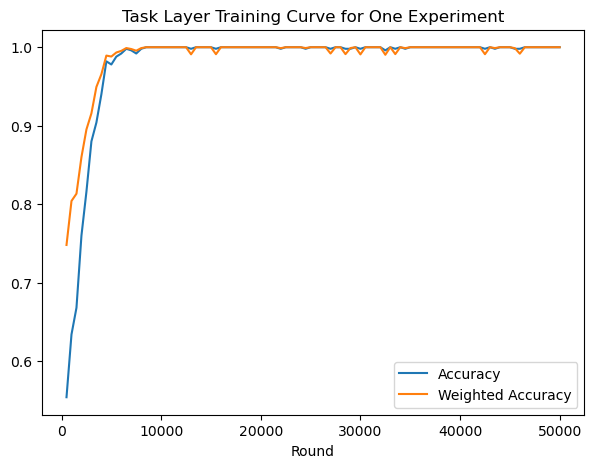

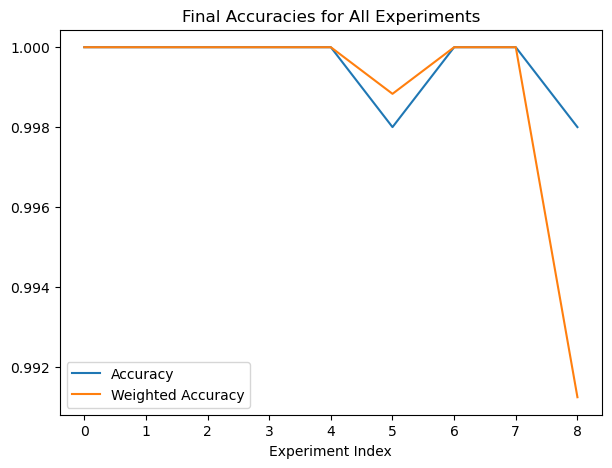

In [57]:
Agent = TreeAgent
exp_list = Two_Obs_Exps
num_rounds = 50000
replay_size = 500
num_optimizer_steps = 10
learning_rate = 0.01
num_cores = 10
trainAndPlotTasks(num_cores=num_cores, Agent=TreeAgent, exp_list=exp_list, num_rounds=num_rounds, replay_size=replay_size, num_optimizer_steps=num_optimizer_steps, learning_rate=learning_rate)